This is a tutorial for Python 2.7

# pyphysio library

## 4. Miscellaneous

In this tutorial we consider other functions and techniques for the advanced usage of pyphysio.

In particular we present the following topics
1. More about segmentation: custom segmentation and label management

### 4.1 More about segmentation

We reproduce here the main steps for the processing of an ECG signal

In [1]:
# import libraries
from __future__ import division
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline 

# import all pyphysio classes and methods
import pyphysio as ph

# import data and creating a signal
ecg_data = ph.TestData.ecg()

fsamp = 2048
ecg = ph.EvenlySignal(values = ecg_data, sampling_freq = fsamp, signal_nature = 'ecg')

# Step 1: Filtering and preprocessing
# (optional) IIR filtering : remove high frequency noise
ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096


# Step 2: Information Extraction
ibi = ph.BeatFromECG()(ecg)

# (optional) edit IBI
# ibi_ok = ph.Annotate(ecg, ibi)()

# Step 3: Computation of physiological indicators

# create fake label
label = np.zeros(1200)
label[300:600] = 1
label[900:1200] = 2

label = ph.EvenlySignal(label, sampling_freq = 10, signal_nature = 'label')

# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

#### 4.1.1 Creation of custom segments

To create custom segments we need to define the start and stop instants of each segment:

In [2]:
t_start = [0.5, 15, 98.7]
t_stop = [5, 21, 110.4]

And then use the function `CustomSegments` to use the defined instants for the segmentation:

In [3]:
#custom windows
custom_segments = ph.CustomSegments(begins = t_start, ends = t_stop)

Then the processing can be continued as usual:

In [4]:
indicators, col_names = ph.fmap(custom_segments, hrv_indicators, ibi)

print(indicators)

[[0.5 5 None 0.91645507812500004 0.015074690195319547 0.014550965583196922]
 [15 21 None 0.75897216796875 0.0085281206896286321 0.012043760232400008]
 [98.7 110.4 None 0.8412214006696429 0.032466062173435395
  0.021056496090773407]]


Note that we obtained three rows, corresponding to the three custom segments we defined above.

#### 4.1.2 Creation of segments using the information about the experiment sessions

We can use the information about the experiment sessions to automatically segment the signal in order to have a unique segment for each session:

In [5]:
#custom windows
label_segments = ph.LabelSegments(labels=label)

Then the processing can be continued as usual:

In [6]:
indicators, col_names = ph.fmap(label_segments, hrv_indicators, ibi)
print(indicators[:, :4])

[[   0.           30.            0.            0.84098075]
 [  30.           60.            1.            0.87795123]
 [  60.           90.            0.            0.88465074]
 [  90.          120.            2.            0.84574382]]


Note that we obtained four rows, corresponding to the four different sessions of the experiment.

#### 4.1.3 Management of the labels

In case we want to keep track of the portion of the experiment each segment belongs to, we should add the information associated to the experiment sessions to the segmentation function (as saw in 2.1 and 2.2, Step 3).

For instance, in case of a custom segmentation:

In [7]:
t_start = [0.5, 15, 78.7]
t_stop = [5, 21, 110.4]

custom_segments = ph.CustomSegments(begins = t_start, ends = t_stop, labels = label)

Therefore, the third column of the matrix obtained from the computation of the indicators will contain the information about the session the segment was taken from.

In [8]:
indicators, col_names = ph.fmap(custom_segments, hrv_indicators, ibi)

print(indicators[:, :3])

[[  0.5   5.    0. ]
 [ 15.   21.    0. ]]


Note that we obtain only two segments and we miss the last one.
This is because, according to the information about the experiment sessions, the third segment belongs to two different sessions:

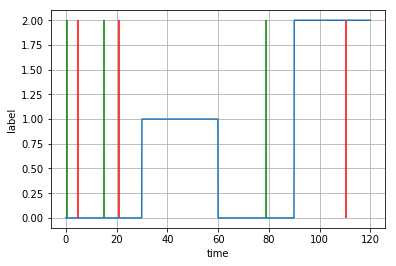

In [9]:
plt.figure()
label.plot() #plot the label signal
plt.vlines(t_start, 0, 2, 'g') #plot the start of the segments, green vertical lines
plt.vlines(t_stop, 0, 2, 'r') #plot the end of the segments, red vertical lines

In this special case the function cannot assign the window to a specific experimental session.
In addition, a signal might end before the end of a segment (e.g. due to disconnection).

There are two parameters that can be used ina segmentation function to handle these special cases:
* **`drop_mixed`**: whether to drop the segments that present mixed values of the labels. It is True by default;
* **`drop_cut`**: whether to drop the segments in which the segmented signal ends before the end of the segment. It is True by default.

Some examples below:

In [10]:
t_start = [0.5, 15, 78.7]
t_stop = [10, 21, 110.4]

# drop_mixed = False --> keep also the segments belonging to different experiment sessions
custom_segments = ph.CustomSegments(begins = t_start, ends = t_stop, labels = label, drop_mixed=False)
indicators, col_names = ph.fmap(custom_segments, hrv_indicators, ibi)

print(indicators[:, :3])

[[0.5 10 0.0]
 [15 21 0.0]
 [78.7 110.4 None]]


In [11]:
t_start = [0.5, 15, 78.7]
t_stop = [10, 21, 130.4] # endo of the last segments has been changed: 110.4 --> 130.40

# drop_mixed = False --> keep also the segments belonging to different experiment sessions
# drop_cut = True (default) --> drop the segments in which the signal ends before the end of the segment
custom_segments = ph.CustomSegments(begins = t_start, ends = t_stop, labels = label, drop_mixed=False)
indicators, col_names = ph.fmap(custom_segments, hrv_indicators, ibi)

print(indicators[:, :3])

[[  0.5  10.    0. ]
 [ 15.   21.    0. ]]


In [12]:
t_start = [0.5, 15, 78.7]
t_stop = [10, 21, 130.4] # endo of the last segments has been changed: 110.4 --> 130.40

# drop_mixed = False --> keep also the segments belonging to different experiment sessions
# drop_cut = False --> keep also the segments in which the signal ends before the end of the segment
custom_segments = ph.CustomSegments(begins = t_start, ends = t_stop, labels = label, drop_mixed=False, drop_cut=False)
indicators, col_names = ph.fmap(custom_segments, hrv_indicators, ibi)

print(indicators[:, :3])

[[0.5 10 0.0]
 [15 21 0.0]
 [78.7 120.0 None]]


### 4.2 Use pickle to save and load signals

You may find useful to store the signals resulting from the intermediate results of the signal processing procedure.

`pyphysio` provides the **`to_csv(FILENAME)`** method to save a signal as a .csv file:

In [13]:
SAVEDIR = '/home/myhome' # set where you will save the data!
os.chdir(SAVEDIR) 

ibi.to_csv('IBI.csv')

However the process of load back the csv file into a Signal to continue the processing is not straightforward.

It is therefore suggested, especially when the signals will not be analysed with other software (e.g. R, spreadsheets etc), to use:
* **`to_pickle(FILENAME)`** function to save the signal in a binary-compressed file;
* **`from_pickle(FILENAME)`** to load the saved file back into another script.

Text(0,0.5,'ibi2')

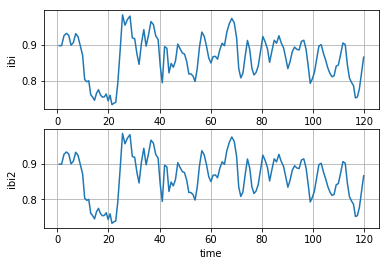

In [14]:
SAVEDIR = '/home/andrea' # set where you will save the data!
os.chdir(SAVEDIR) 

ibi.to_pickle('IBI.pkl')

ibi2 = ph.from_pickle('IBI.pkl')

ax1 = plt.subplot(211)
ibi.plot()
plt.ylabel('ibi')
plt.subplot(212, sharex=ax1)
ibi2.plot()
plt.ylabel('ibi2')

### [TODO]: 4.x Creation of custom processing functions

In addition to the functions provided by pyphysio, you can also define your custom processing algorithms.
You will need to write a function with the following syntax:

```

```